## Diffusion Models vs. GANs vs. VAE

### HW4 @ DL Course, Dr. Soleymani, Spring 2023



In this notebook, we are going to implement Variational AutoEncoder (VAE), Denoising Diffusion Probabilistic Model (DDPM) on the FashionMNIST dataset. 

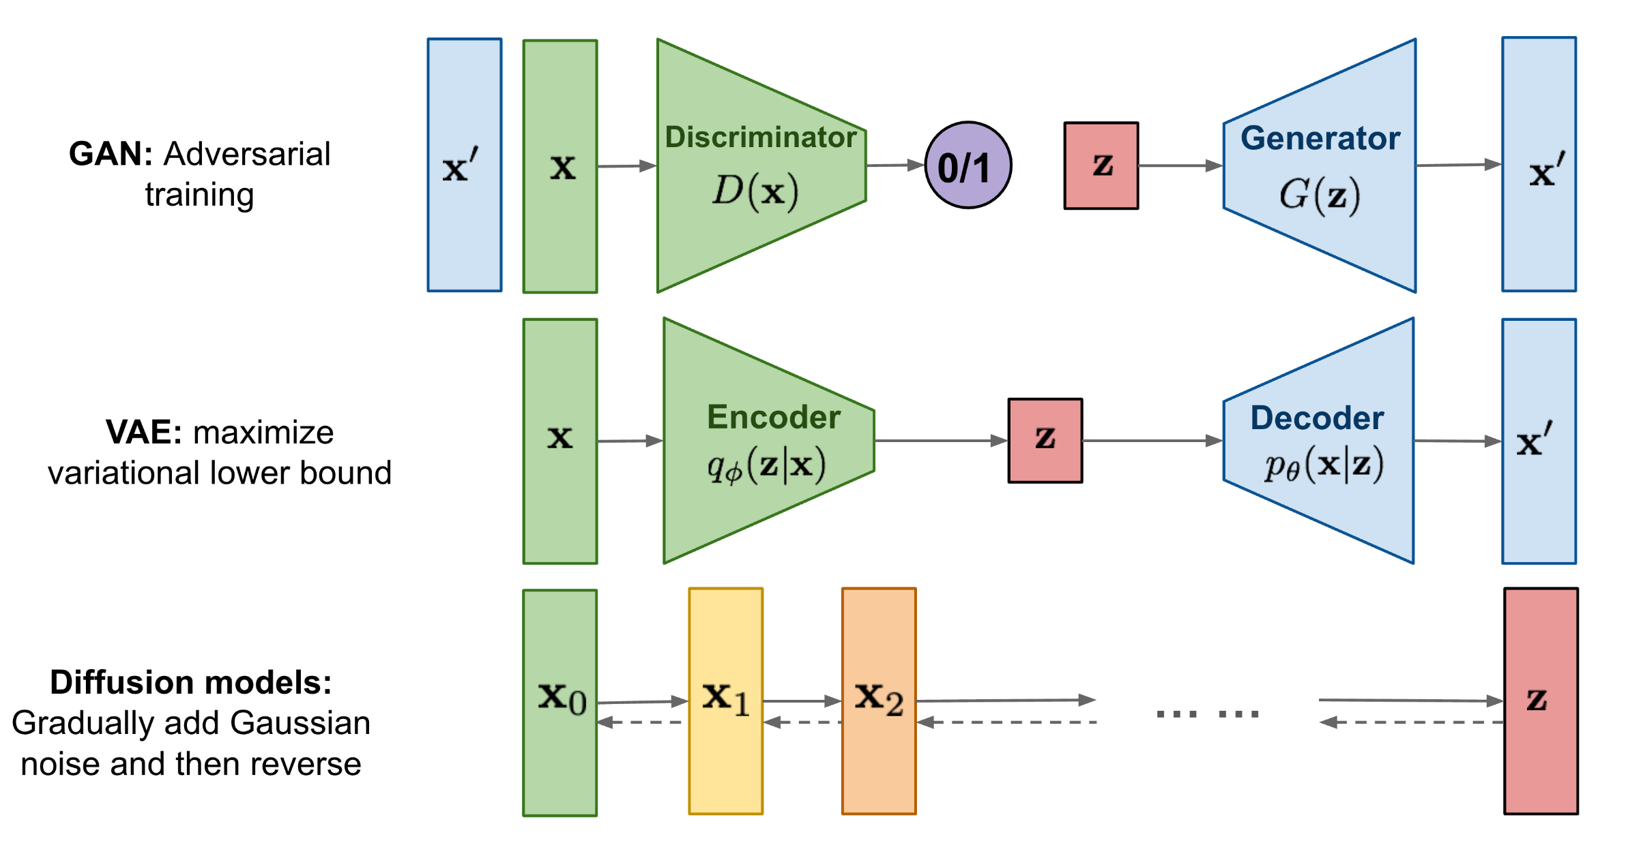


## Dataset

We are going to work on the FashionMNIST dataset. FashionMNIST consists of a training set of 60,000 examples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image associated with a label from 10 classes. We are going to use the training split in this notebook. You can use `dataloader` to train your models. Also, you can use `plot_samples` to plot a sequence of images (e.g. iteratively denoised images by DDPM).

In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.2 MB/s eta 0:00:00


In [2]:
import math
from inspect import isfunction
from functools import partial
import random
import IPython

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
from torch.optim import Adam

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import matplotlib.pyplot as plt

In [3]:
from torchvision import transforms 
from torch.utils.data import DataLoader
from torch import optim
from tqdm.notebook import tqdm
from torch.autograd import Variable 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

import logging, copy
import torch
from torch import optim
import torch.nn as nn
import numpy as np
from fastprogress import progress_bar
import os

BATCH_SIZE = 8
IMG_SIZE = 32 
C_IN = 1
LR = 2e-5
EPOCHS = 500

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

100%|██████████| 26421880/26421880 [00:01<00:00, 17168742.03it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269784.39it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5041334.72it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8717108.19it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



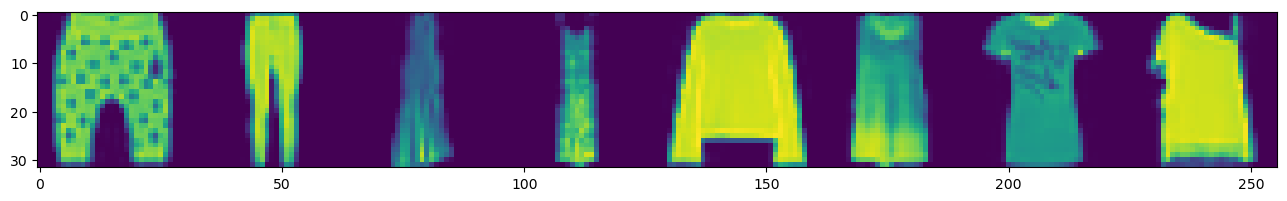

In [4]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  
        transforms.Lambda(lambda t: (t * 2) - 1) 
    ]

    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.FashionMNIST(root=".", download=True, 
                                         train=True, transform=data_transform)
    return data


def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, 
                        shuffle=True, drop_last=True)
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

## DDPM

Denoising diffusion probabilistic models (DDPMs) learn to generate images by gradually denoising a completely random pattern in a step-by-step process. The model learns a set of diffusion steps that describe how the noise evolves through time and a denoising function that removes the noise at each time step. The denoising function is typically implemented as a neural network that takes in the noisy data and the time step as input and outputs the denoised data. After iterative denoising steps over a time index, an image from the training distribution is generated. The overall procedure of training and sampling from DDPM is represented in the following pseudocodes from DDPM paper. For more details on the loss function and the sampling process, please refer to the course slides and the paper.

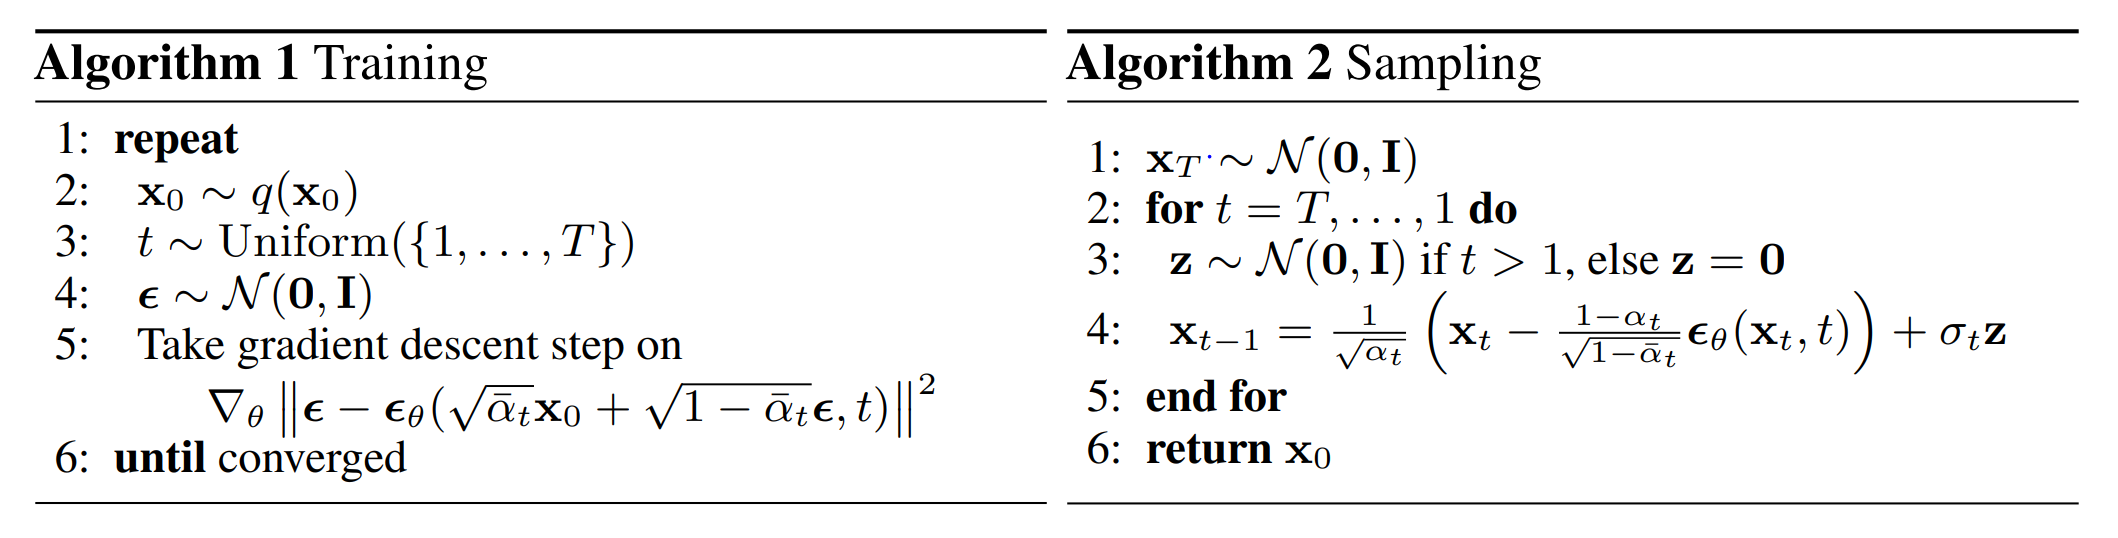

The pseudocode shows that the loss function is defined as an MSE on per time step noise and the predicted noise for the current time step. So we only need to train a model that learns to reverse the noise from an input image at a specific time step. In this notebook, we will use the architecture proposed by the paper, a UNet with image and time as the inputs and predicted noise as the output. They augment the regular UNet with several sub-modules and techniques such as ResNets, Attention modules, etc. We describe the expected architecture for this notebook:

+ *ResNet:* As a base sub-module, we define each ResNet block as two consecutive convolutional layers with a GELU activation in between and Group Normalization after each convolutional layer. You can use this module in Down/Up blocks. Also, by removing the residual connection, you can use this block as a convolutional network throughout the network.
+ *Attention:* This is also a sub-module consisting of a Layer Normalization, Multi-head Attention (use from `torch.nn`), a residual connection, a feed-forward network, and another residual connection.
+ *Conditional UNet:* Each Up/Down block in UNet accepts positionally-encoded time as an input. The time index is encoded and added to the output of the block. You can use the sinusoidal position embeddings proposed in [Attention is All You Need.](https://arxiv.org/pdf/1706.03762.pdf)

You can implement the following structure for UNet:

+ Convolutional block
+ Down block
+ Attention 
+ Down block
+ Attention
+ Down block
+ Attention

+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)

+ Up block
+ Attention
+ Up block
+ Attention
+ Up block
+ Attention
+ Convolutional block

In [5]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def one_param(m):
    "get model first parameter"
    return next(iter(m.parameters()))


class Attention(nn.Module):
    def __init__(self, channels):
        super(Attention, self).__init__()
        self.channels = channels        
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)


class ConvResNet(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvResNet(in_channels, in_channels, residual=True),
            ConvResNet(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            ConvResNet(in_channels, in_channels, residual=True),
            ConvResNet(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256, remove_deep_conv=False):
        super().__init__()
        self.time_dim = time_dim
        self.remove_deep_conv = remove_deep_conv
        self.inc = ConvResNet(c_in, 16)
        self.down1 = Down(16, 32)
        self.sa1 = Attention(32)
        self.down2 = Down(32, 64)
        self.sa2 = Attention(64)
        self.down3 = Down(64, 64)
        self.sa3 = Attention(64)


        if remove_deep_conv:
            self.bot1 = ConvResNet(64, 64)
            self.bot3 = ConvResNet(64, 64)
        else:
            self.bot1 = ConvResNet(64, 128)
            self.bot2 = ConvResNet(128, 128)
            self.bot3 = ConvResNet(128, 64)

        self.up1 = Up(128, 32)
        self.sa4 = Attention(32)
        self.up2 = Up(64, 16)
        self.sa5 = Attention(16)
        self.up3 = Up(32, 16)
        self.sa6 = Attention(16)
        self.outc = nn.Conv2d(16, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=one_param(self).device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def unet_forwad(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        if not self.remove_deep_conv:
            x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output
    
    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        return self.unet_forwad(x, t)



  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

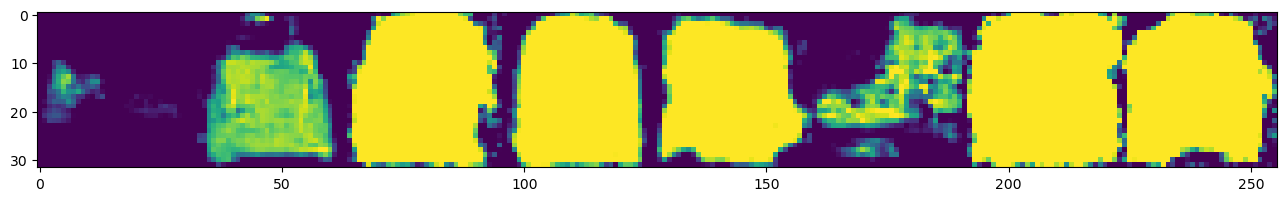

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

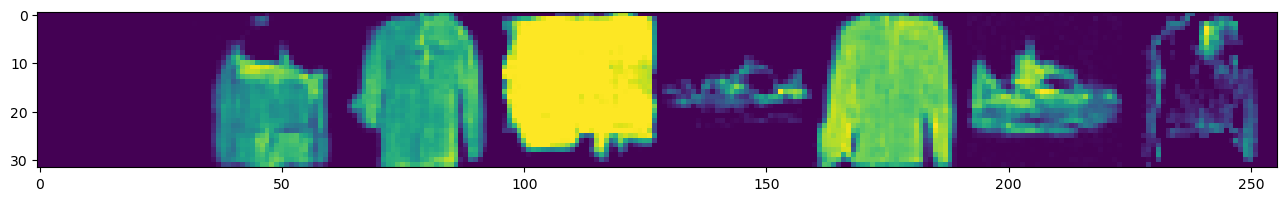

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

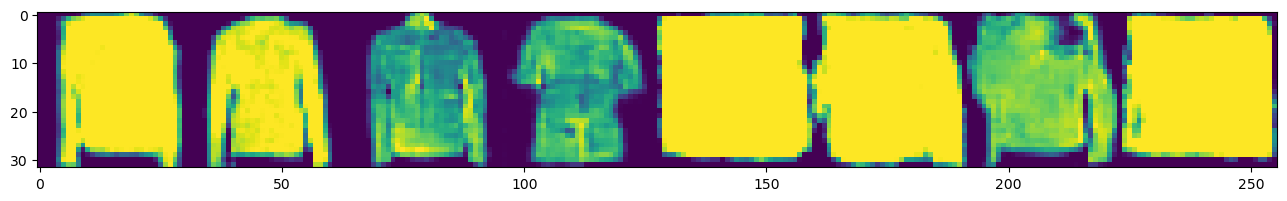

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

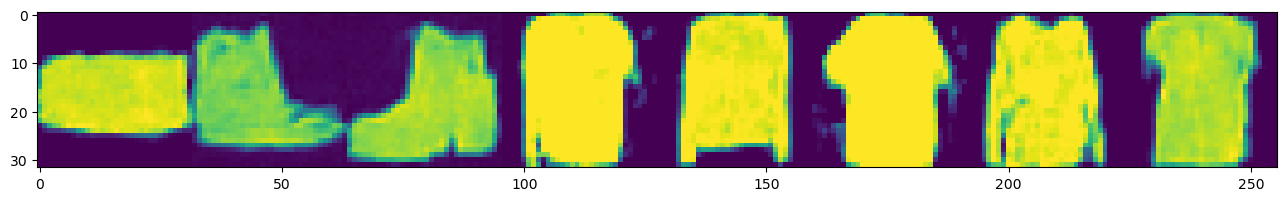

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

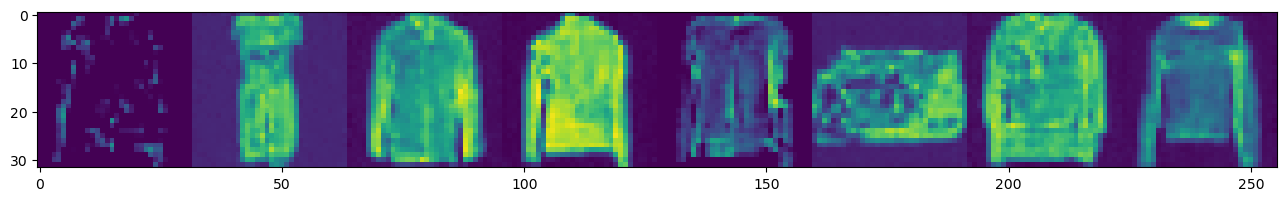

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

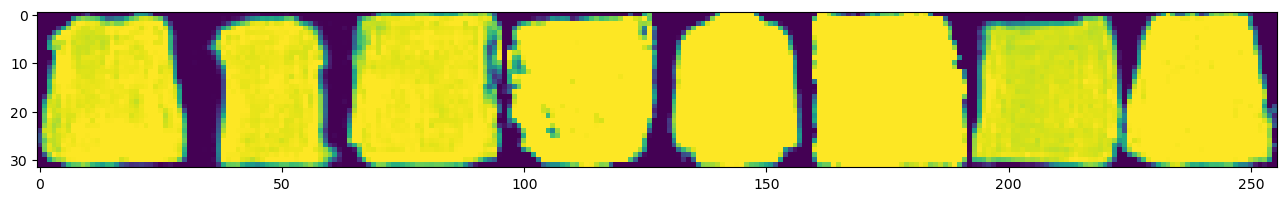

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

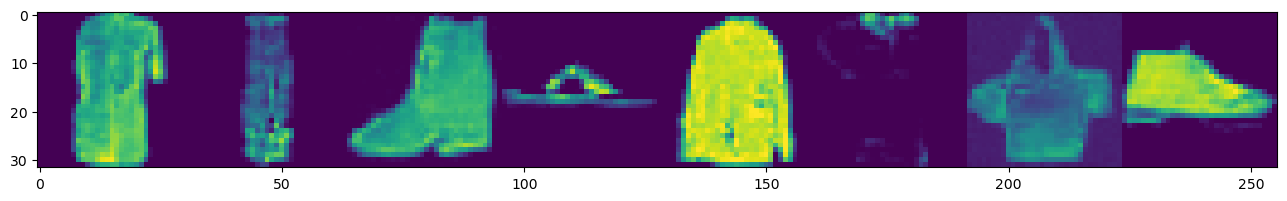

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

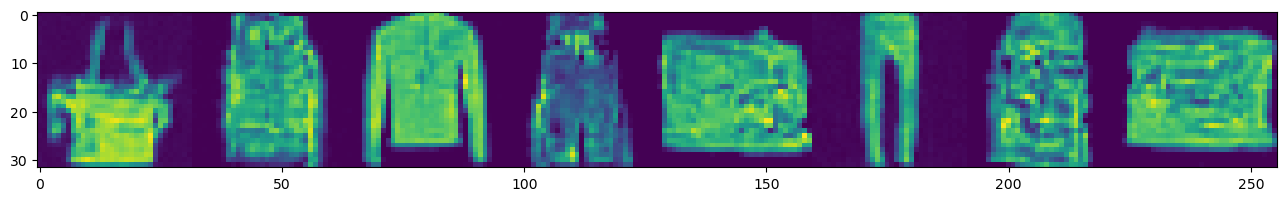

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

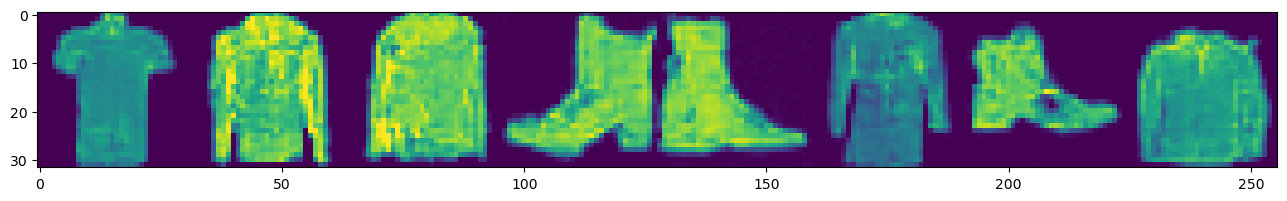

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

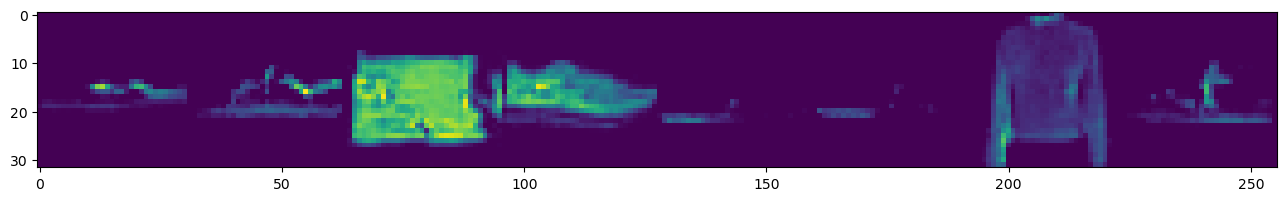

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

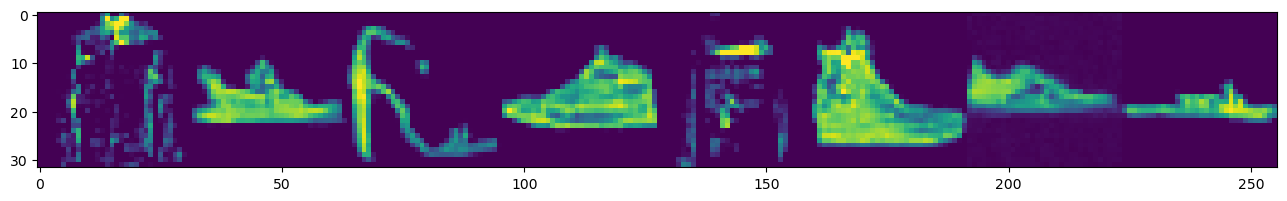

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

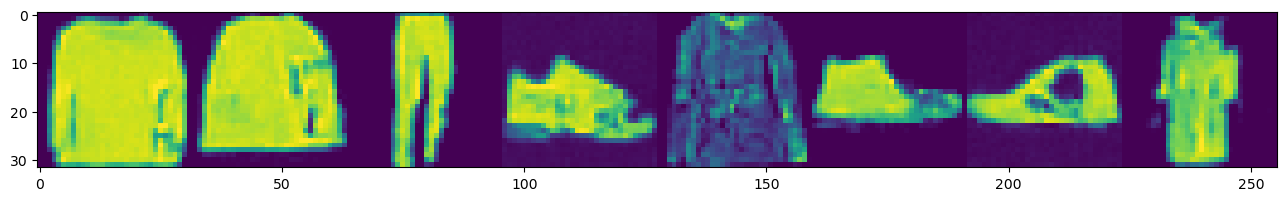

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

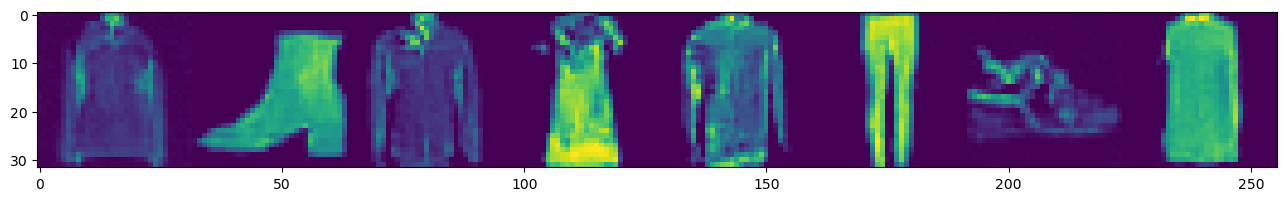

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

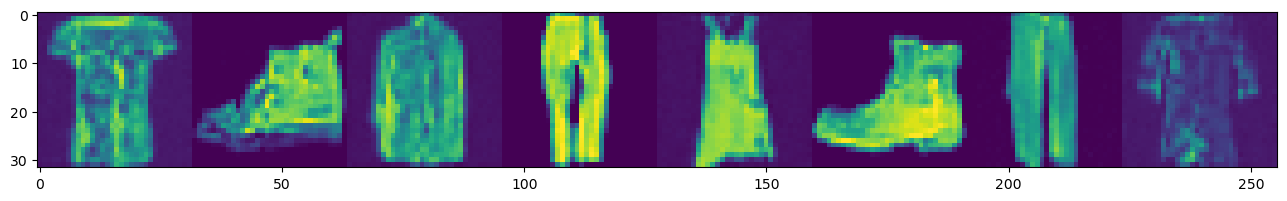

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

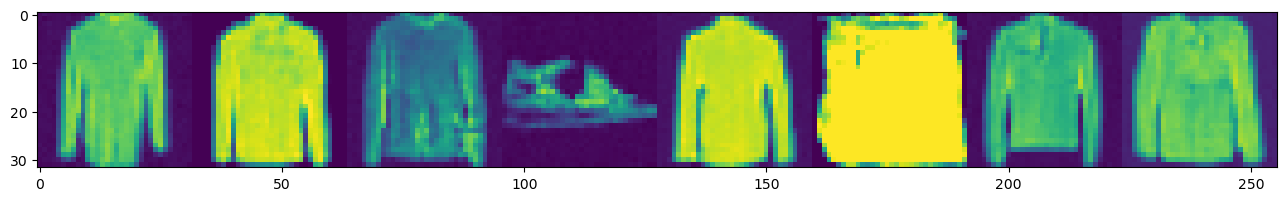

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

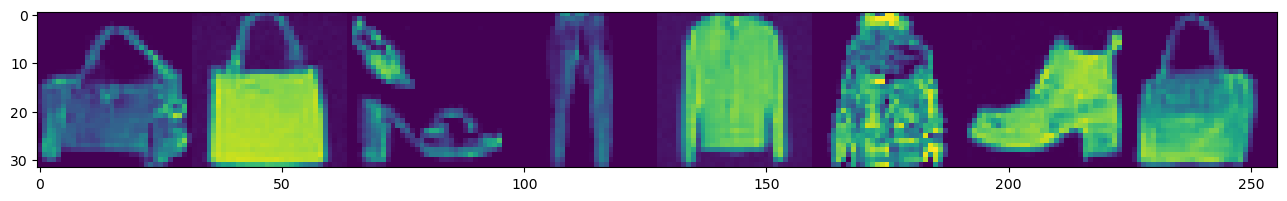

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

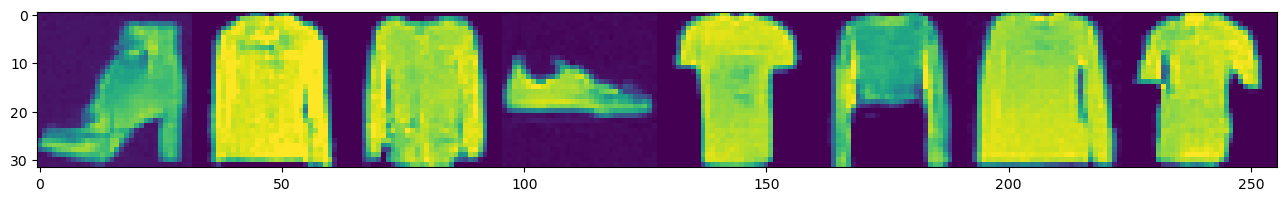

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

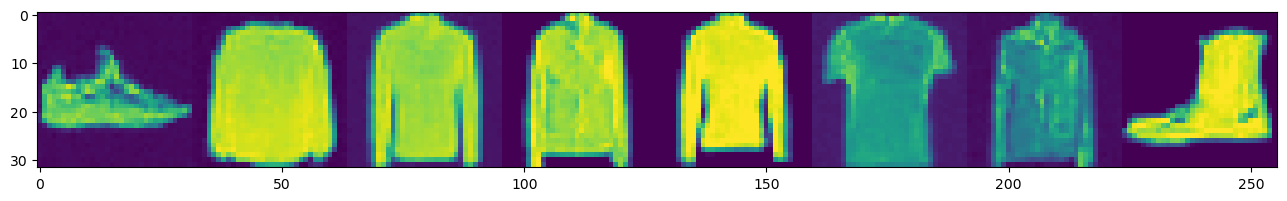

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

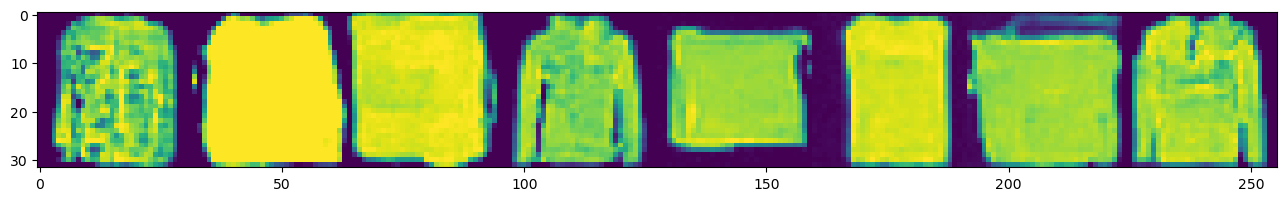

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

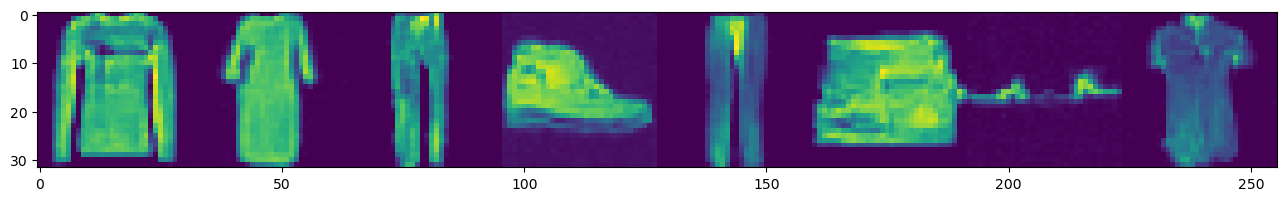

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

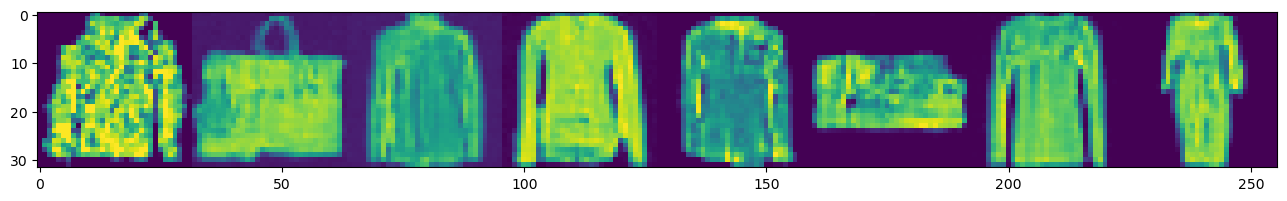

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

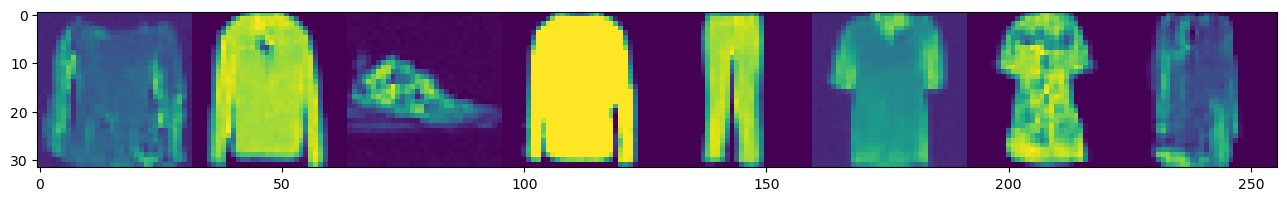

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

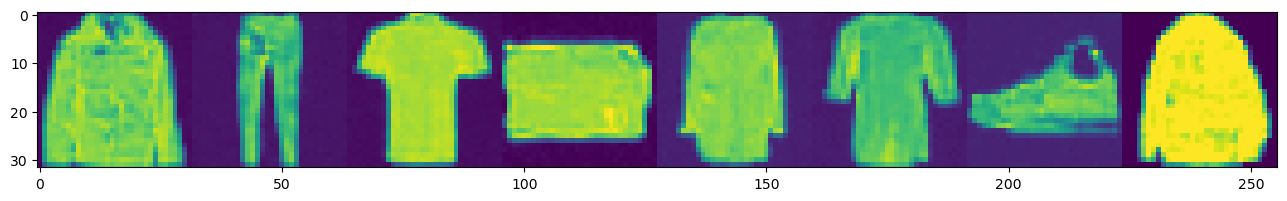

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

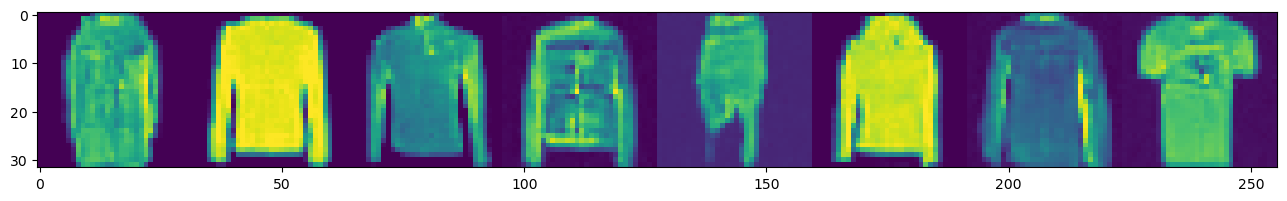

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

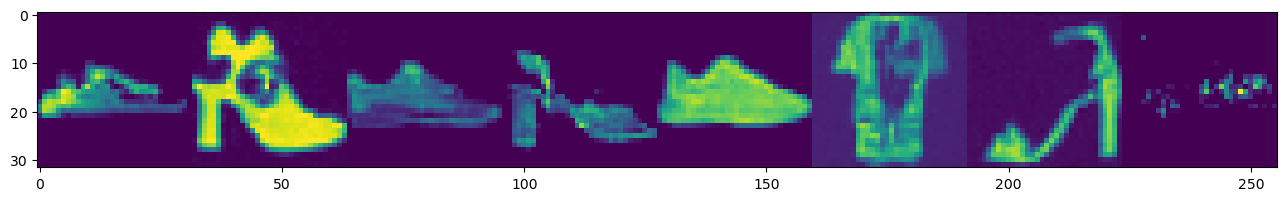

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

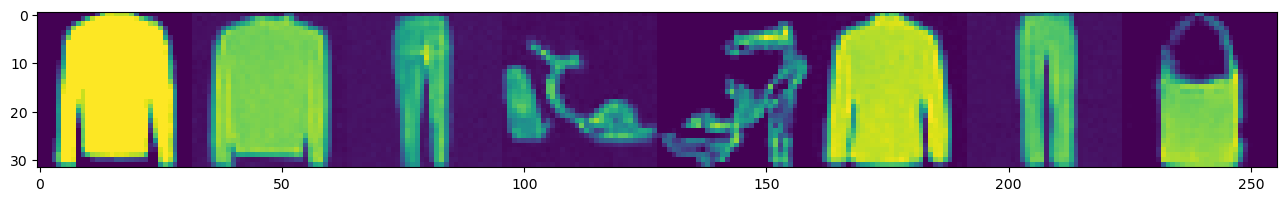

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

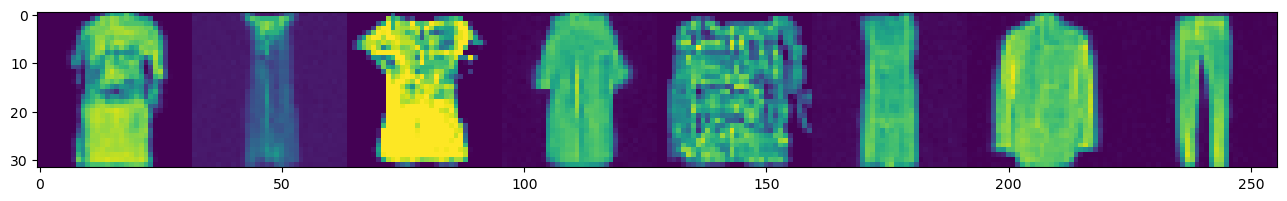

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

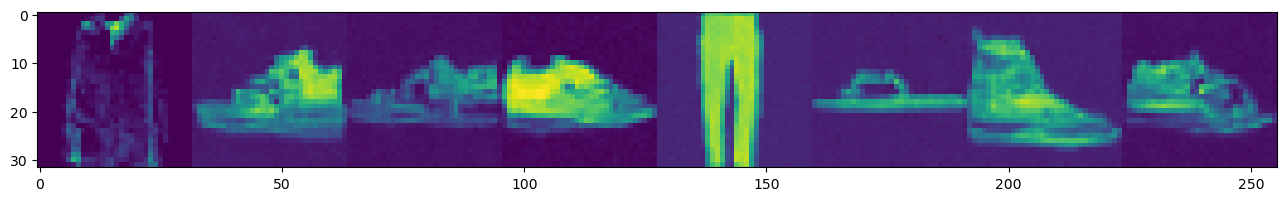

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

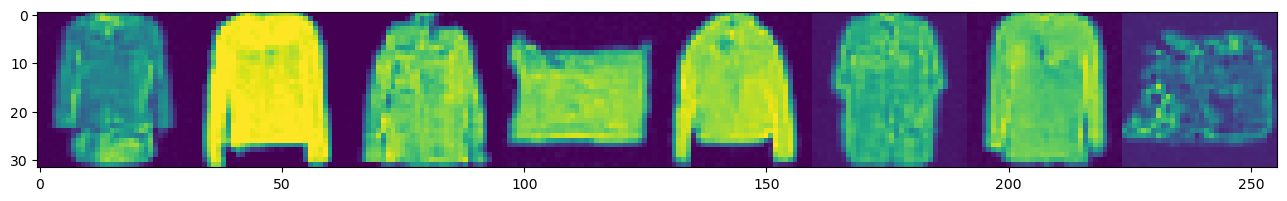

  0%|          | 0/7500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

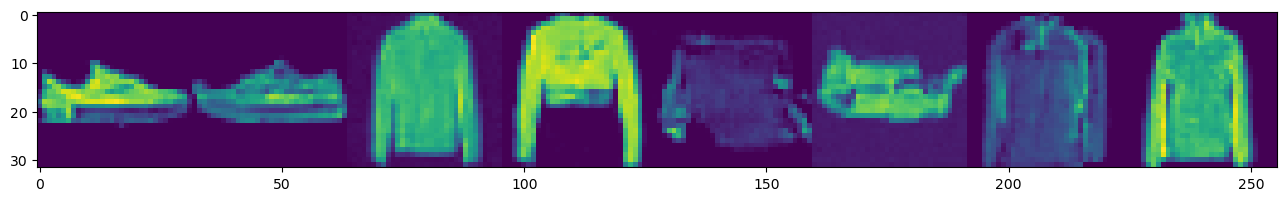

In [7]:
epochs = 30
batch_size = 128
image_size = 32
device = "cuda"
lr = 3e-4

class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda", dataloader=None):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.dataloader = dataloader
        self.model = UNet().to(device)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr)
        self.mse = nn.MSELoss()

    def cosine_beta_schedule(self, timesteps, s=0.008):
          """
          cosine schedule as proposed in https://arxiv.org/abs/2102.09672
          """
          steps = timesteps + 1
          x = torch.linspace(0, timesteps, steps)
          alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
          alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
          betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
          return torch.clip(betas, 0.0001, 0.9999)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, n):
        logging.info(f"Sampling {n} new images....")
        self.model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = self.model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        self.model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

    def plot_sample(self):
        sampled_images = self.sample(8)
        plot_images(sampled_images)

    def train(self):    
        l = len(self.dataloader)
        losses = []
        for epoch in range(epochs):
            epoch_loss = []
            pbar = tqdm(dataloader)
            for i, (images, _) in enumerate(pbar):
                images = images.to(device)
                t = self.sample_timesteps(images.shape[0]).to(device)
                x_t, noise = self.noise_images(images, t)
                predicted_noise = self.model(x_t, t)
                loss = self.mse(noise, predicted_noise)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                pbar.set_postfix(MSE=loss.item())
                epoch_loss.append(loss.item())
            self.plot_sample()
            losses.append(torch.mean(torch.tensor(epoch_loss)).item())
        return losses
diffusion = Diffusion(img_size=image_size, device=device, dataloader=dataloader)
ddpm_history = diffusion.train()

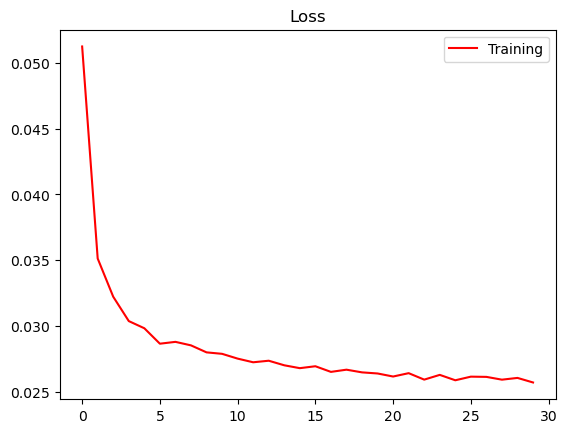

In [8]:
plt.plot (range (len (ddpm_history)), ddpm_history, 'r-', label = 'Training')
plt.title ('Loss')
plt.legend ()

In [9]:
torch.save(diffusion.model.state_dict(), './ddpm_weights.pth')

In [10]:
import json
ddpm_histo = dict()
ddpm_histo["loss"] = ddpm_history
with open('./ddpm_loss_history.json', 'w') as f:
    json.dump(ddpm_histo, f)

### ❓ **Question 4**
> + *(4 points)* How can we generate images from a specific target class in DDPM?

 We can adopt a conditioning approach. Here's a general outline of how you can modify DDPM to generate images from a specific target class:

1. Conditional Model: Modify the unet network in DDPM to be conditional, meaning it takes an additional input representing the target class information. This input can be in the form of class labels, class embeddings, or any other suitable representation. The generator should learn to generate samples that align with the provided target class.(Unet can get concatenation of noise and onehot vector of class as its input, and can also recieve this onehot vector in mid conv block inside encoder and decoder)

> In out implementation: we combine label embedding with time embedding  

2. Conditional Sampling: During sampling or inference, provide the desired target class information as input to the unet. By conditioning the unet on the target class, it should generate samples that resemble the specified class.
 

In [11]:
class UNet_conditional(UNet):
    def __init__(self, c_in=1, c_out=1, time_dim=256, num_classes=None, **kwargs):
        super().__init__(c_in, c_out, time_dim, **kwargs)
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def forward(self, x, t, y=None):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        return self.unet_forwad(x, t)

+-------------------------------------------+------------+
|                  Modules                  | Parameters |
+-------------------------------------------+------------+
|          inc.double_conv.0.weight         |    144     |
|          inc.double_conv.1.weight         |     16     |
|           inc.double_conv.1.bias          |     16     |
|          inc.double_conv.3.weight         |    2304    |
|          inc.double_conv.4.weight         |     16     |
|           inc.double_conv.4.bias          |     16     |
| down1.maxpool_conv.1.double_conv.0.weight |    2304    |
| down1.maxpool_conv.1.double_conv.1.weight |     16     |
|  down1.maxpool_conv.1.double_conv.1.bias  |     16     |
| down1.maxpool_conv.1.double_conv.3.weight |    2304    |
| down1.maxpool_conv.1.double_conv.4.weight |     16     |
|  down1.maxpool_conv.1.double_conv.4.bias  |     16     |
| down1.maxpool_conv.2.double_conv.0.weight |    4608    |
| down1.maxpool_conv.2.double_conv.1.weight |     32    

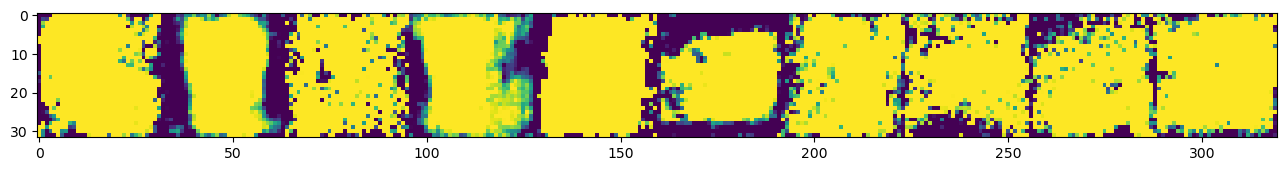

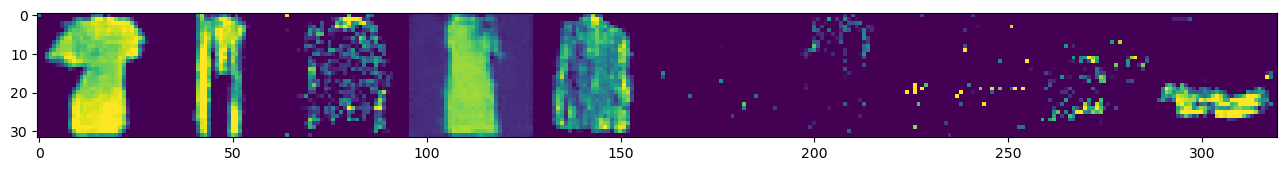

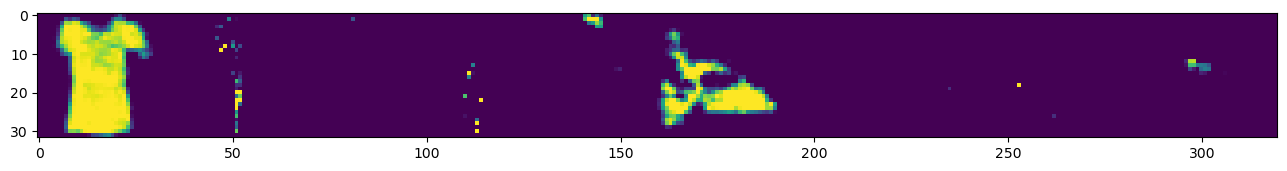

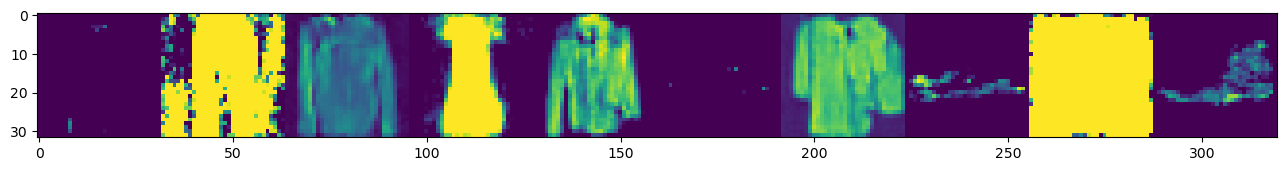

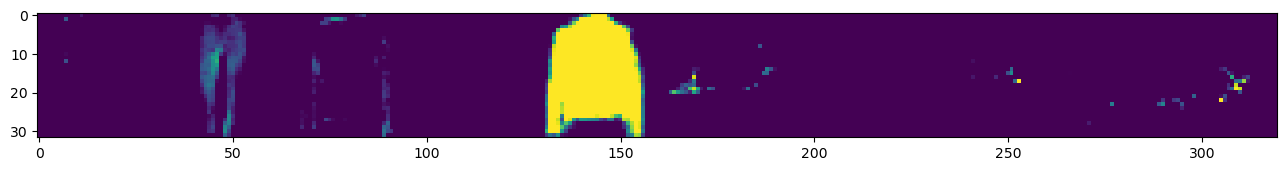

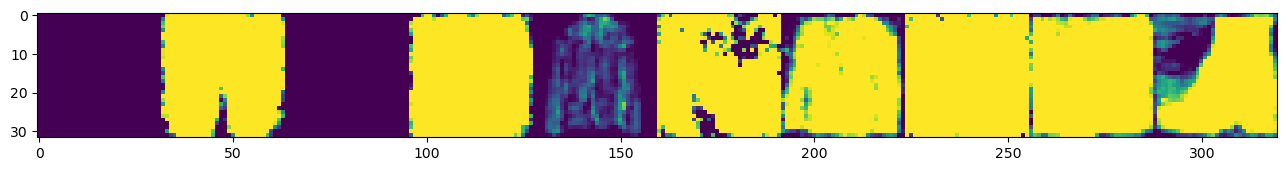

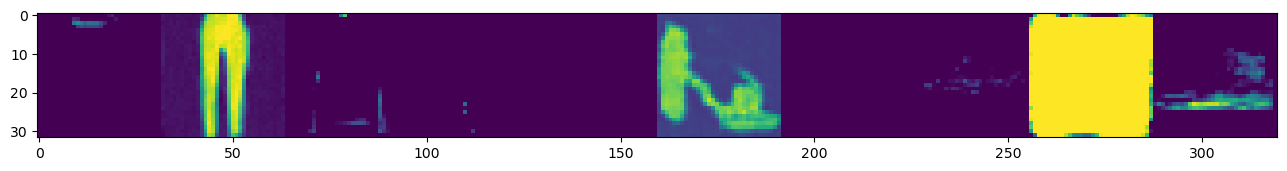

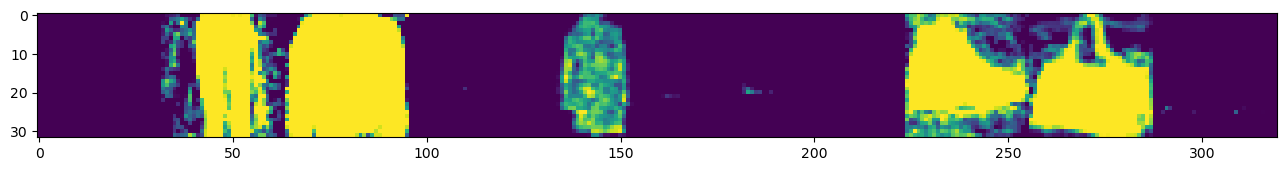

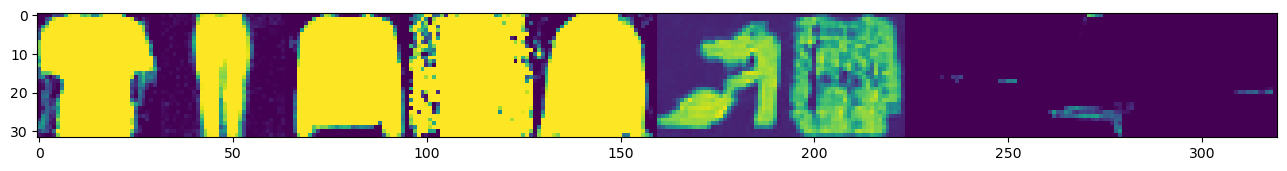

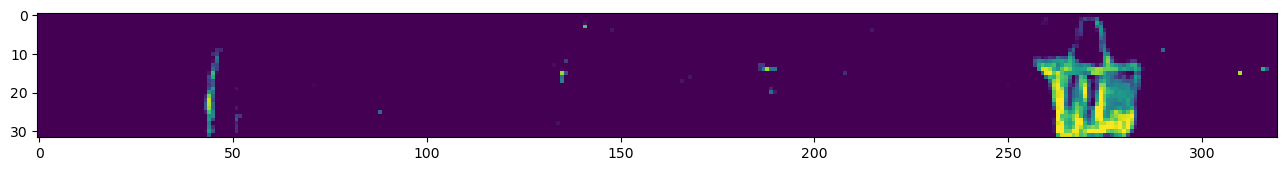

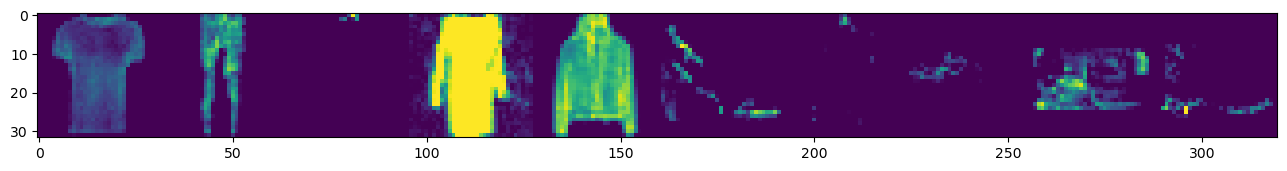

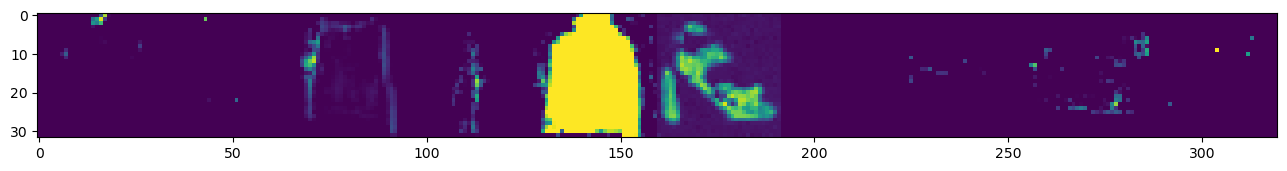

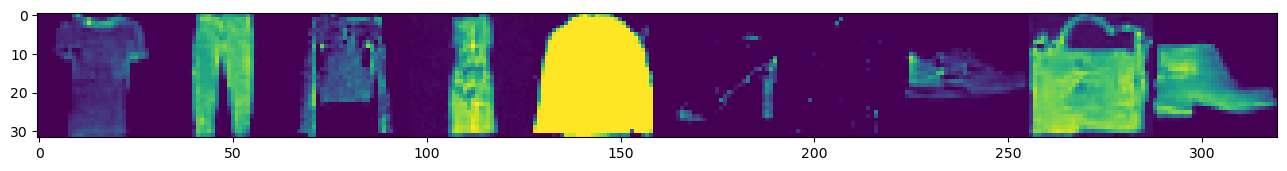

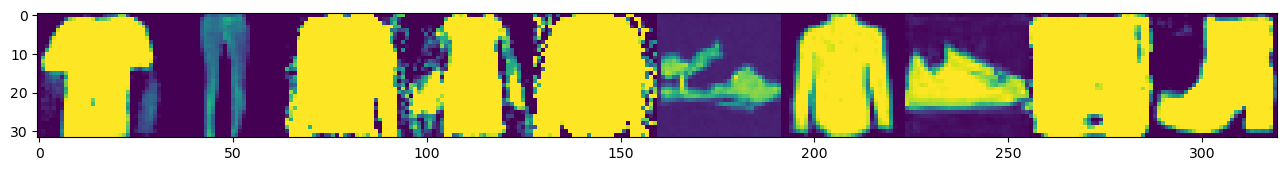

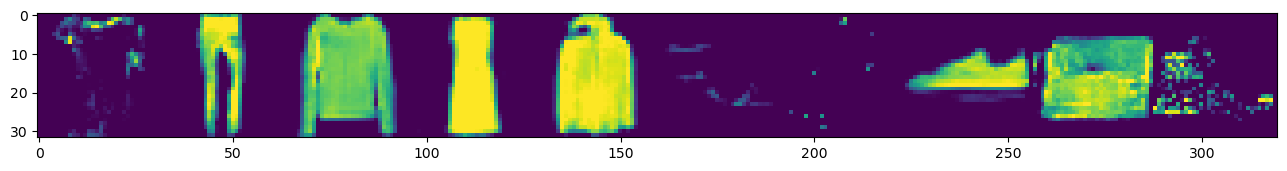

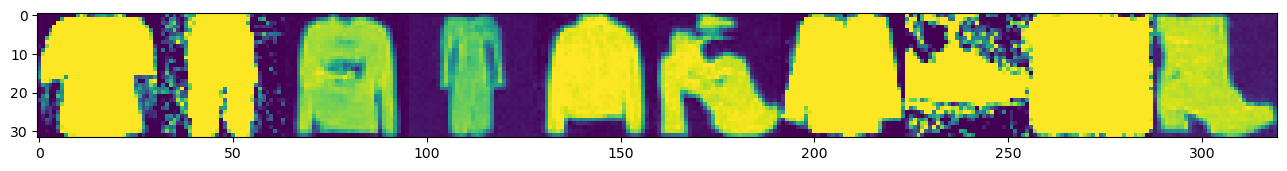

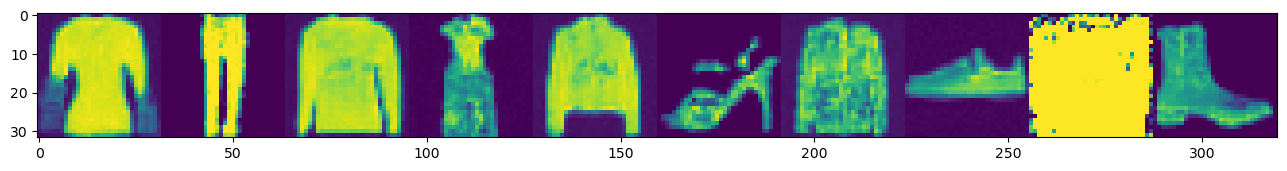

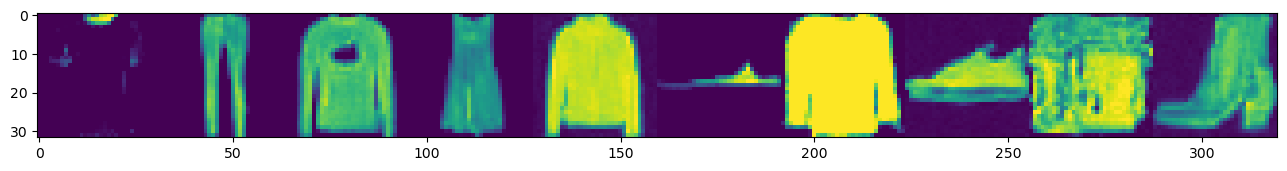

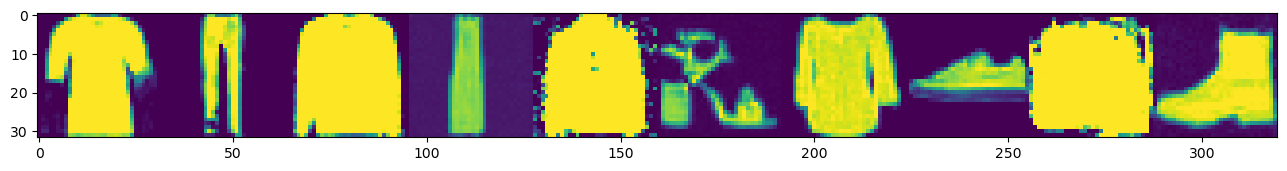

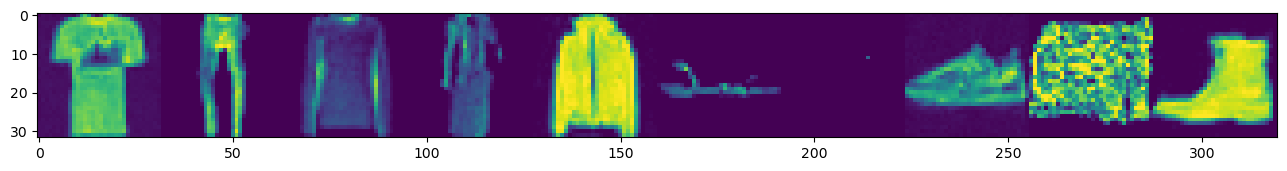

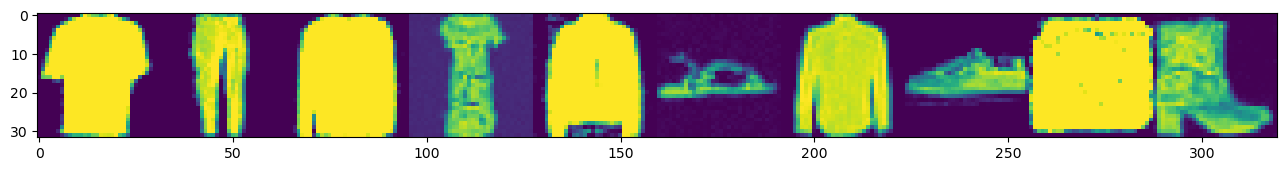

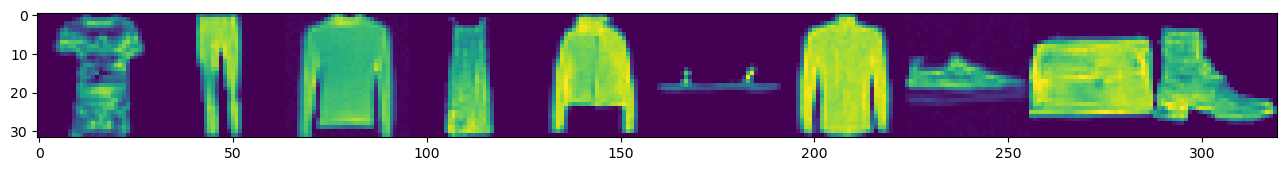

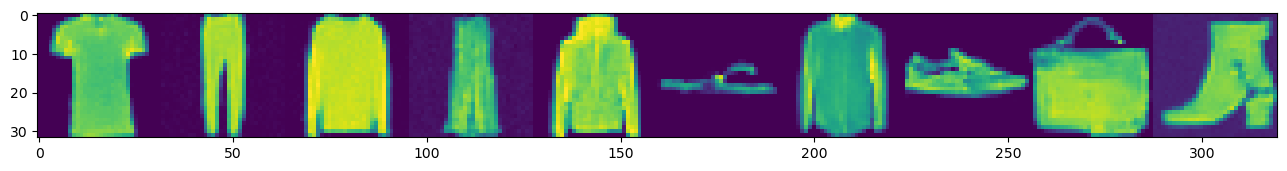

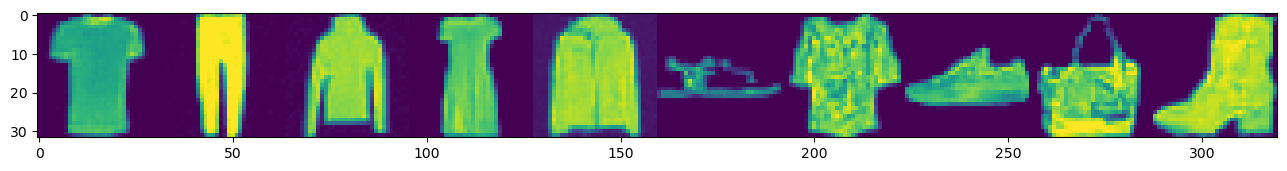

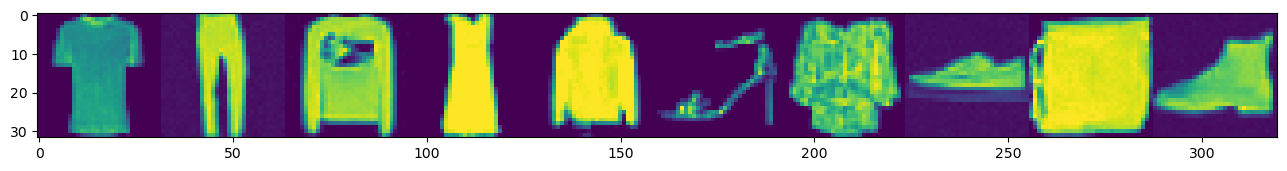

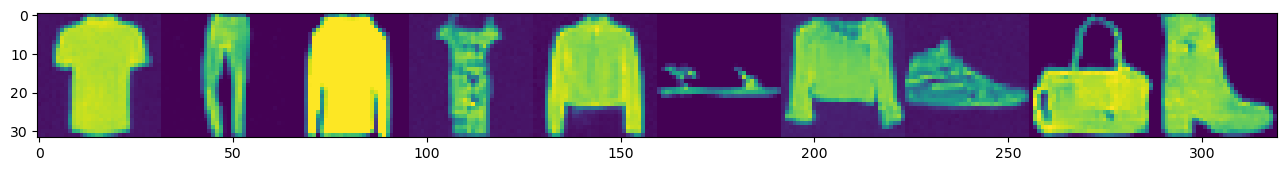

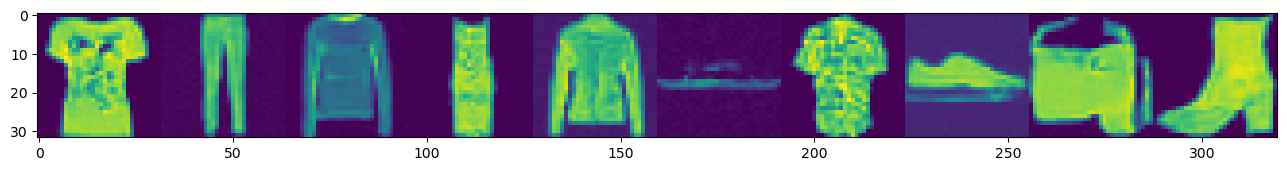

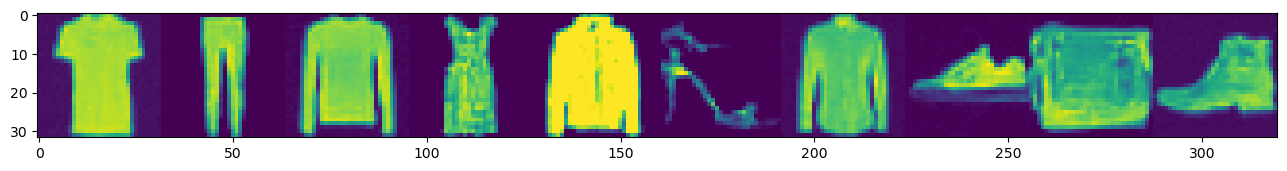

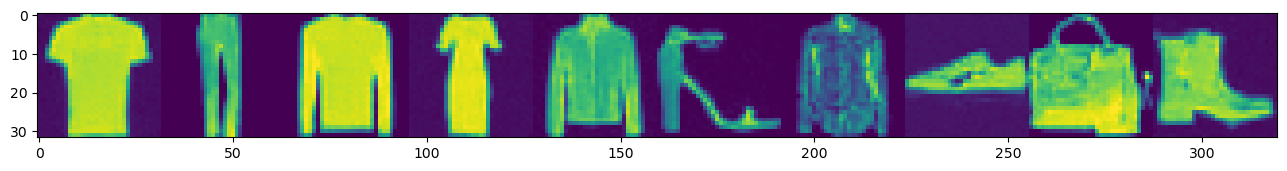

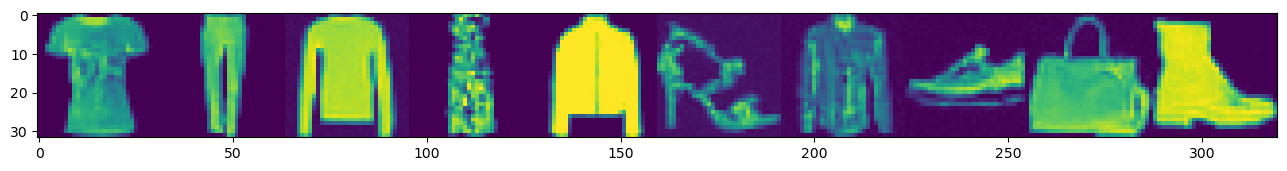

In [12]:
epochs = 30
noise_steps=1000
seed = 42
batch_size = 128
img_size = 32
num_classes = 10
train_folder = "train"
device = "cuda"
slice_size = 1
do_validation = False
fp16 = True
num_workers=10
lr = 5e-3

data = load_transformed_dataset()
dataloader = DataLoader(data, shuffle=True, drop_last=True, batch_size=batch_size)

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


class DDPMManager:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, num_classes=10, c_in=1, c_out=1, device="cuda", dataloader=None, **kwargs):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.model = UNet_conditional(c_in, c_out, num_classes=num_classes, **kwargs).to(device)
        self.device = device
        self.c_in = c_in
        self.num_classes = num_classes

        self.train_dataloader = dataloader
        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr, eps=1e-5)
        self.scheduler = optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=lr, 
                                                 steps_per_epoch=len(self.train_dataloader), epochs=epochs)
        self.mse = nn.MSELoss()
        self.scaler = torch.cuda.amp.GradScaler()
    
    def cosine_beta_schedule(self, timesteps, s=0.008):
        """
        cosine schedule as proposed in https://arxiv.org/abs/2102.09672
        """
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def noise_images(self, x, t):
        "Add noise to images at instant t"
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ
    
    @torch.inference_mode()
    def sample(self, labels, cfg_scale=3):
        n = len(labels)
        logging.info(f"Sampling {n} new images....")
        self.model.eval()
        with torch.inference_mode():
            x = torch.randn((n, self.c_in, self.img_size, self.img_size)).to(self.device)
            for i in progress_bar(reversed(range(1, self.noise_steps)), total=self.noise_steps-1, leave=False):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = self.model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = self.model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

    def train_step(self, loss):
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.scheduler.step()

    def one_epoch(self, train=True):
        avg_loss = 0.
        if train: self.model.train()
        else: self.model.eval()
        pbar = progress_bar(self.train_dataloader, leave=False)
        for i, (images, labels) in enumerate(pbar):
            with torch.autocast("cuda") and (torch.inference_mode() if not train else torch.enable_grad()):
                images = images.to(self.device)
                labels = labels.to(self.device)
                t = self.sample_timesteps(images.shape[0]).to(self.device)
                x_t, noise = self.noise_images(images, t)
                if np.random.random() < 0.1:
                    labels = None
                predicted_noise = self.model(x_t, t, labels)
                loss = self.mse(noise, predicted_noise)
                avg_loss += loss
            if train:
                self.train_step(loss)
            pbar.comment = f"MSE={loss.item():2.3f}"
        return avg_loss.mean().item()

    def plot_sample(self):
        labels = torch.arange(self.num_classes).long().to(self.device)
        sampled_images = self.sample(labels=labels)
        plot_images(sampled_images)

    def load(self, model_cpkt_path, model_ckpt="ckpt.pt"):
        self.model.load_state_dict(torch.load(os.path.join(model_cpkt_path, model_ckpt)))

    def train(self):
        losses = []
        for epoch in progress_bar(range(epochs), total=epochs, leave=True):
            logging.info(f"Starting epoch {epoch}:")
            loss  = self.one_epoch(train=True)    
            losses.append(loss)        
            self.plot_sample()
        return losses


torch.manual_seed(53)
random.seed(53)
np.random.seed(53)

conditional_ddpm = DDPMManager(noise_steps, img_size=img_size, num_classes=num_classes, dataloader=dataloader)
count_parameters(conditional_ddpm.model)
conditional_ddpm_history = conditional_ddpm.train()

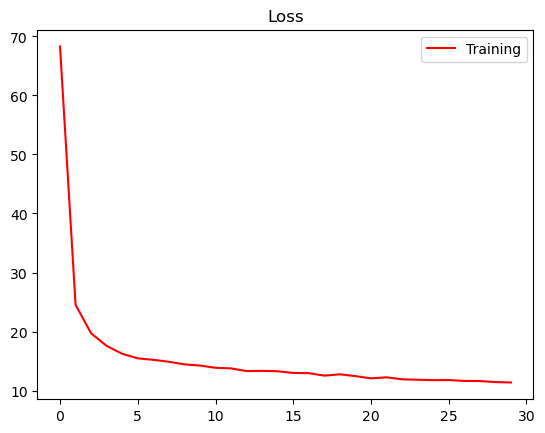

In [13]:
plt.plot (range (len (conditional_ddpm_history)), conditional_ddpm_history, 'r-', label = 'Training')
plt.title ('Loss')
plt.legend ()

In [14]:
torch.save(conditional_ddpm.model.state_dict(), './conditional_ddpm.pth')

In [15]:
import json
ddpm_hist = dict()
ddpm_hist["loss"] = conditional_ddpm_history
with open('./conditional_ddpm_loss_history.json', 'w') as f:
    json.dump(ddpm_hist, f)